In [503]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import plotly.graph_objs as go
from pandas.tseries.offsets import BDay

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from util.functions import get_data_ticker, decompor_sinal, obter_sazonalidade_periodo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import keras
from keras.layers import Input, LSTM, Dense, Dropout
from keras import Sequential


### Parâmetros

In [504]:
EMPRESA = 'B3SA3.SA'
SEED = 42
qtdTreino = .9

# features = ['Close', 'prev-day-1', 'prev-day-2', 'prev-day-3', 'mm_5', 'mm_21', 'Close_diff']
features = ['Close','Close_diff', 'mm_5', 'mm_21', 'RSI_14']
features_trend = ['Close','tomorrow']
target = 'tomorrow'

n_past = 15
days_to_predict = 50
# n_features = len(features)

np.random.seed(SEED)
tf.random.set_seed(SEED)

### Funções

In [505]:
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

In [506]:
def prepare_new_record(df, new_record, date_index, rolling=1):
    data_orig = pd.DataFrame({'Close': new_record}, index=[date_index])
    data_orig = data_orig.rename_axis('Date')
    data_orig = pd.concat([df,data_orig])
    data_hist = pd.DataFrame(data_orig['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].rolling(rolling).mean().shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].rolling(rolling).mean().shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].rolling(rolling).mean().shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist['tomorrow'] = data_hist['Close'].rolling(rolling).mean().shift(-1)
    data_hist['Close_diff'] = data_hist['Close'].diff(1)
    # Ajuste para o último registro
    if len(data_hist) > 1:
        data_hist.iloc[-1, data_hist.columns.get_loc('Close_diff')] = data_hist['Close'].iloc[-1] - data_hist['Close'].iloc[-2]
    else:
        data_hist['Close_diff'].iloc[-1] = 0  # Define 0 caso não haja histórico suficiente

    data_hist['tomorrow'].fillna(0, inplace = True)
    delta = data_hist['Close'].diff(1)
    gain = delta.where(delta > 0, 0)  # Ganhos
    loss = -delta.where(delta < 0, 0)  # Perdas
    avg_gain = gain.rolling(window=14, min_periods=1).mean()  # Média de ganhos
    avg_loss = loss.rolling(window=14, min_periods=1).mean()  # Média de perdas
    rs = avg_gain / avg_loss  # Cálculo do RS (força relativa)
    rsi = 100 - (100 / (1 + rs))  # Cálculo do RSI
    data_hist['RSI_14'] = rsi 
    return data_hist.tail(1)

In [507]:
def increment_data_df(df, last_predict, offset=0):
   if df.tail(1)['tomorrow'].values[0] == 0:
      return df
   # dia_util = gerar_dias_uteis(1, offset)[0]
   last_date = df.index[-1]
   dia_util = pd.date_range(start=last_date + BDay(1), periods=1, freq=BDay())

   return pd.concat([df, prepare_new_record(df, last_predict, dia_util[0])])

In [508]:
def evaluate_model(y_true, y_pred):
    # Calcular as métricas de desempenho
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Criar um dicionário com as métricas
    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }
    
    return metrics

In [509]:
def aplicar_tendencia_coluna(df, coluna, period = 20):
    season = decompor_sinal(df[coluna], period=period, two_sided=False )
    tendencia = season.trend
    tendencia.dropna()
    df.loc[tendencia.dropna().index].copy()
    df[coluna] = tendencia

## Obter dados

In [510]:
dados = get_data_ticker(EMPRESA, period='5y', dropna=False)
dados['Close_diff'] = dados['Close'].diff().dropna()

dados.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


## Decomposição

### Análises para descobrir o melhor "period"

#### ACF

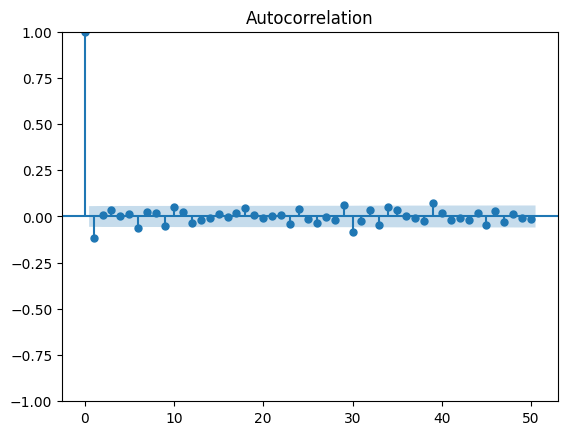

In [511]:
plot_acf(dados['Close_diff'], lags=50) 
plt.show()

### Seasonal decompose

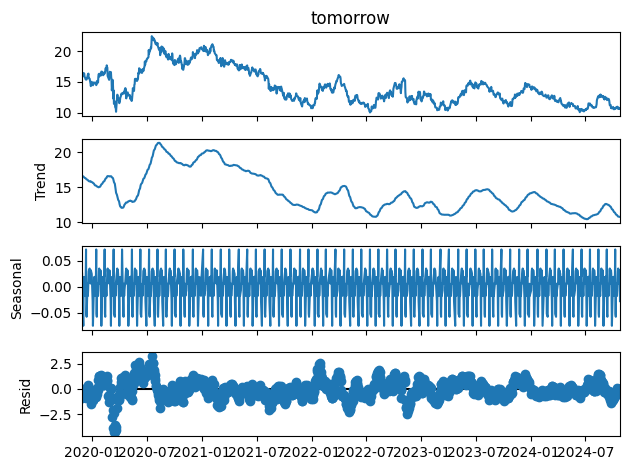

In [512]:
if 'tomorrow' in features_trend:
    season = decompor_sinal(dados['tomorrow'], period=20 )
    tendencia = season.trend

    season.plot()
    plt.show()

In [513]:

# season.seasonal.index[-1]
dates_index = pd.date_range(start=season.seasonal.index[-1] + BDay(1), periods=days_to_predict, freq=BDay())
new_seasonal = obter_sazonalidade_periodo(days_to_predict, season.seasonal)
season_full = pd.concat([season.seasonal, pd.Series(new_seasonal, index=dates_index)], axis=0);

## Pré processamento

In [514]:
for f in features_trend:
    aplicar_tendencia_coluna(dados, f)

Text(0.5, 1.0, 'Percentual de diferença entre fechamentos')

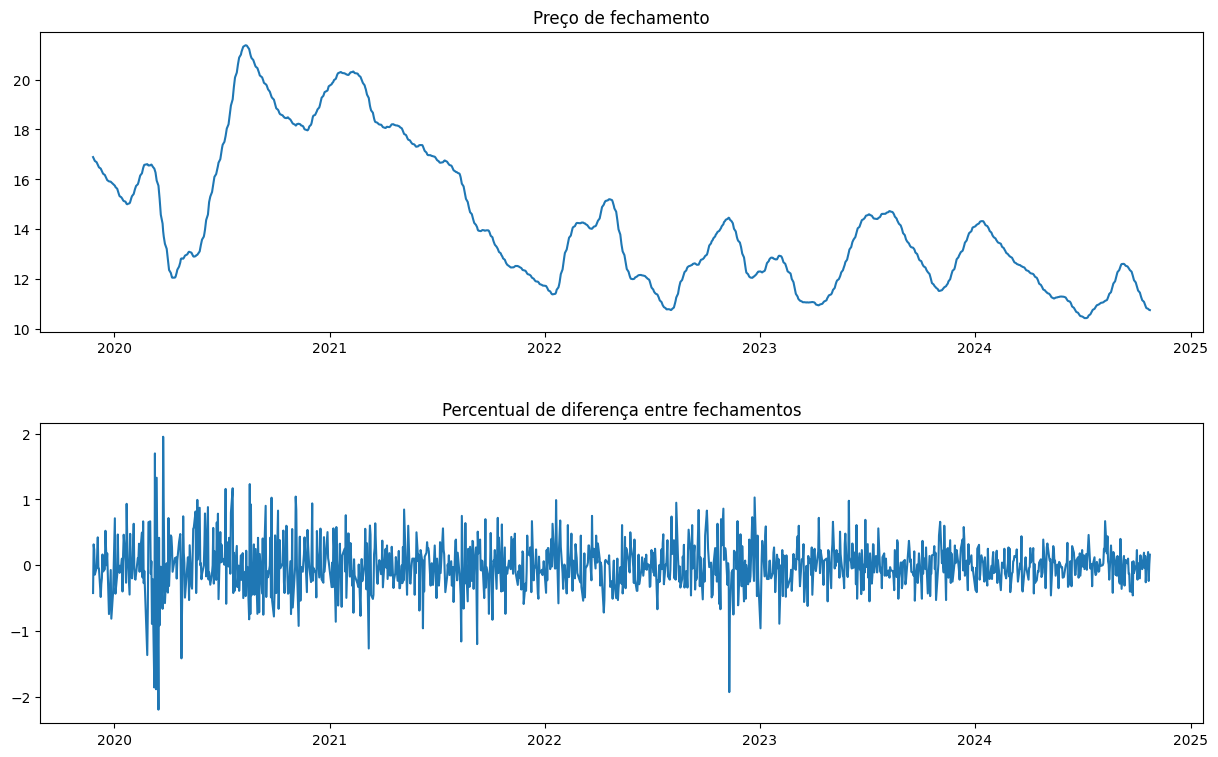

In [515]:
plt.figure(figsize=(15,10))

ax1 = plt.subplot2grid((10,1),(0,0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10,1),(5,0), rowspan=4, colspan=1)
ax1.plot(dados['Close'])
ax1.set_title('Preço de fechamento')

ax2.plot(dados['Close_diff'])
ax2.set_title('Percentual de diferença entre fechamentos')

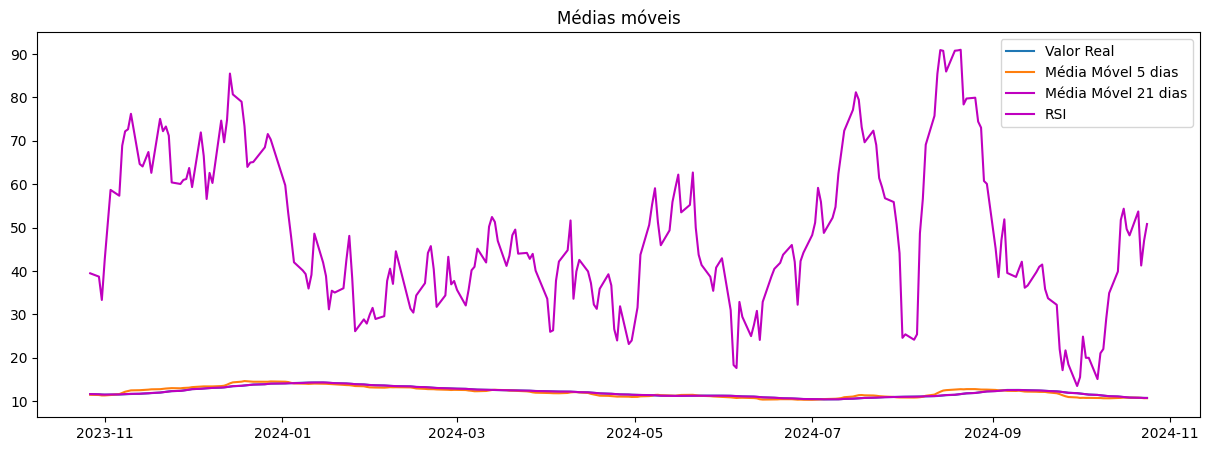

In [516]:
plt.figure(figsize=(15,5))
plt.title("Médias móveis")
plt.plot(dados['Close'][-250:], label="Valor Real")
plt.plot(dados['mm_5'][-250:], label="Média Móvel 5 dias")
plt.plot(dados['mm_21'][-250:], color="m",label="Média Móvel 21 dias")
plt.plot(dados['RSI_14'][-250:], color="m",label="RSI")
plt.legend(loc="upper right")

In [517]:
fig = px.line(dados, y=['mm_5', 'mm_21', 'Close', 'tomorrow'])
fig.update_layout(
    title=dict(text="médias móveis X tendencia", font=dict(size=50), automargin=True, yref='paper')
)
fig.show()

Separando dados de treino e teste

In [518]:
def split_X_y(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), index=df.index, columns=features)
    X, y = create_sequences(df_scaled[features].values, df[target].values, n_past)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=qtdTreino, shuffle=False)
    return (X, y, X_train, X_test, y_train, y_test)

In [519]:
X, y, X_train, X_test, y_train, y_test = split_X_y(dados)

In [520]:
if 'Close' in features:
    close_index = features.index('Close')

    close_values= [X_train[i, :, close_index] for i in range(X_train.shape[0])]
    X_train_plot = [arr[0] for arr in close_values]

    close_values= [X_test[i, :, close_index] for i in range(X_test.shape[0])]
    X_test_plot = [arr[0] for arr in close_values]


In [521]:

dtr_plot = pd.DataFrame({'tomorrow':y_train})
dte_plot = pd.DataFrame({'tomorrow':y_test})
dtr_plot['tipo'] = 'treino'
dte_plot['tipo'] = 'teste'

# Adicionar índices sequenciais
dtr_plot['index'] = range(len(dtr_plot))
dte_plot['index'] = range(len(dtr_plot), len(dtr_plot) + len(dte_plot))

# Concatenar os DataFrames
dados_concat = pd.concat([dtr_plot, dte_plot])

# Criar o gráfico
fig = px.line(dados_concat, x='index', y='tomorrow', color='tipo')

# Atualizar o layout do gráfico
fig.update_layout(
    title=dict(text="Split treino X teste", font=dict(size=50), automargin=True, yref='paper'),
    xaxis_title='Índice',
    yaxis_title='Valor de Fechamento'
)

# Exibir o gráfico
fig.show()

## Modelos

### Prophet

In [522]:
np.random.seed(42)

df_prophet = pd.DataFrame()
df_prophet['ds'] = dados.index
df_prophet['y'] = dados['Close'].reset_index(drop=True)

tamanho_treino = int(len(df_prophet)*.8)
tamanho_teste = int(len(df_prophet)*.2)

df_treino = df_prophet[:tamanho_treino]
df_teste = df_prophet[tamanho_treino:]

modelo_prophet = Prophet()
modelo_prophet.fit(df_treino)

futuro = modelo_prophet.make_future_dataframe(periods=len(df_teste), freq='D')
previsao = modelo_prophet.predict(futuro)

01:12:30 - cmdstanpy - INFO - Chain [1] start processing
01:12:30 - cmdstanpy - INFO - Chain [1] done processing


MSE: 1.72; RMSE: 1.31


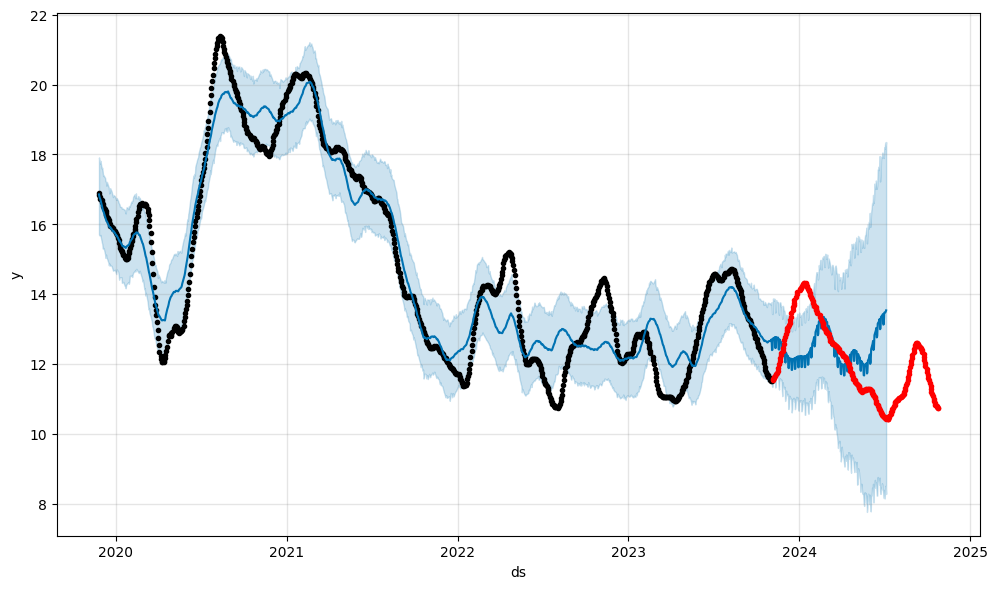

In [523]:
modelo_prophet.plot(previsao)

plt.plot(df_teste['ds'],df_teste['y'],'.r')

from sklearn.metrics import mean_squared_error

df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste, on='ds', how='inner')

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)
print(f'MSE: {mse}; RMSE: {rmse}')

In [524]:
# modelo_prophet = Prophet()
# modelo_prophet.fit(df_prophet)

# futuro = modelo_prophet.make_future_dataframe(periods=0, freq='D')
# previsao = modelo_prophet.predict(futuro)

# df_prophet_sem_outliers = df_prophet[(df_prophet['y'] > previsao['yhat_lower']) & (df_prophet['y'] < previsao['yhat_upper'])]

# modelo_prophet.plot()

### LSTM

#### Criação do modelo

In [525]:
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(X_train.shape[1], X_train.shape[2]), name='Input'))
modelo_lstm.add(LSTM(256, name='LSTM'))
# modelo_lstm.add(Dropout(.2))
# modelo_lstm.add(LSTM(500, return_sequences=False, name='LSTM_2'))
# modelo_lstm.add(Dropout(.2))
# modelo_lstm.add(Dense(256, activation='relu',name='Dense_1'))
# modelo_lstm.add(Dense(128, activation='relu', name='Dense_2'))
# modelo_lstm.add(Dense(64, activation='relu',name='Dense_3'))
# modelo_lstm.add(Dense(32, activation='relu',name='Dense_4'))
# modelo_lstm.add(Dense(16, activation='relu',name='Dense_5'))
modelo_lstm.add(Dense(units=1, name='Output'))

# utilizar optimizer adam ou RMSProp
modelo_lstm.compile(optimizer='RMSProp', loss='mean_squared_error')

In [526]:
modelo_lstm.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 256)            │       268,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,545 (1.02 MB)

 Trainable params: 268,545 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

#### Treinamento do modelo

In [527]:
history = modelo_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, verbose=True)

Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 62.5189 - val_loss: 7.5551
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.0820 - val_loss: 0.5032
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.6844 - val_loss: 2.4970
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.8629 - val_loss: 0.0838
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.6888 - val_loss: 0.1256
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.5977 - val_loss: 0.6749
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.3638 - val_loss: 1.0502
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.2742 - val_loss: 0.4281
Epoch 9/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.1023 - val_loss: 0.1216
Epoch 10/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.8240 - val_loss: 0.7749
Epoch 11/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.8557 - val_loss: 0.6863
Epoch 12/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.

#### Predição do modelo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


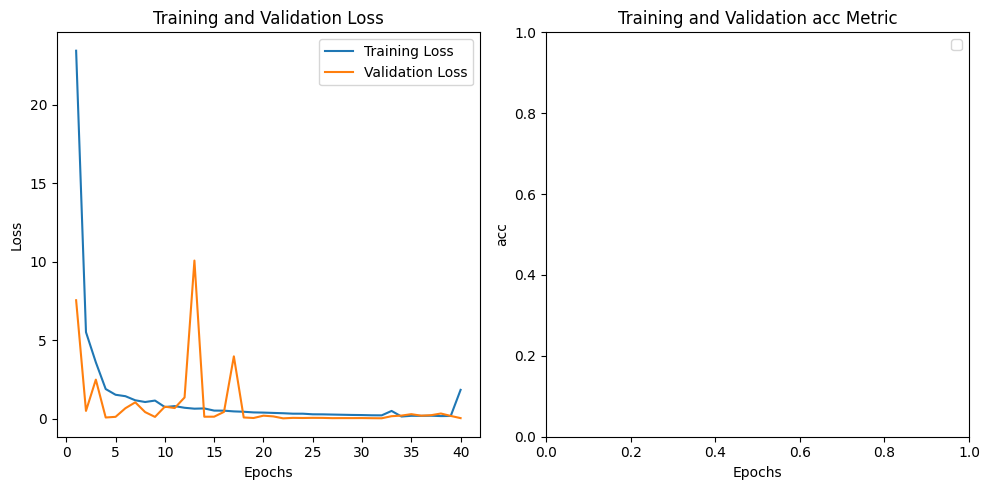

In [528]:
# Extrair métricas de treinamento e validação
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# Criar gráfico
epochs = range(1, len(loss_values) + 1)

# Plot da perda
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Cria uma subtrama com 1 linha e 2 colunas (gráfico da perda à esquerda)
plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot da métrica personalizada
plt.subplot(1, 2, 2)  # Cria uma subtrama com 1 linha e 2 colunas (gráfico da métrica personalizada à direita)
# plt.plot(epochs, acc, label='acc')
# plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and Validation acc Metric')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.tight_layout()  # Garante que os gráficos não se sobreponham
plt.show()

In [529]:
y_pred = modelo_lstm.predict(X_test)
evaluate_model(y_test, y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


{'MSE': 0.04370082765205644,
 'MAE': 0.18085243327558537,
 'RMSE': 0.209047429192651}

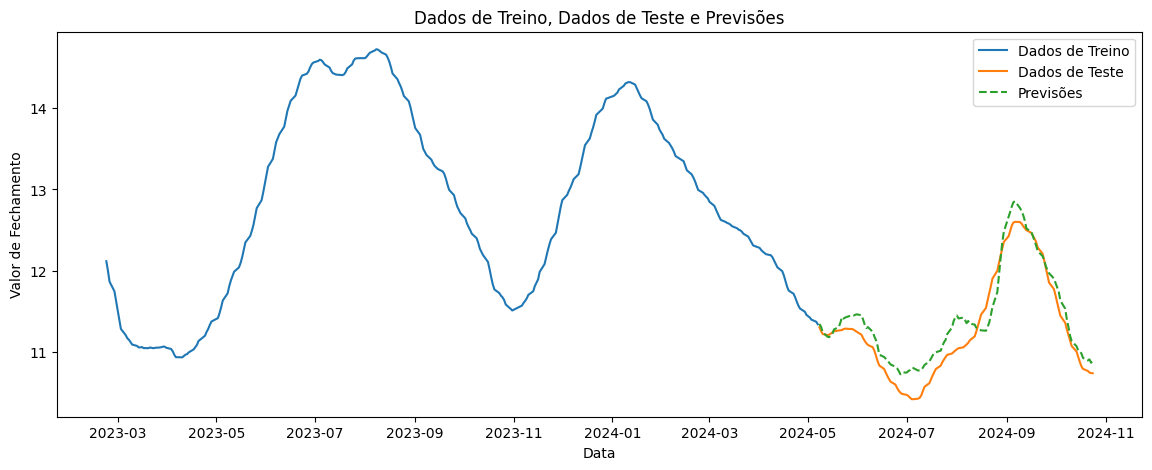

In [530]:
index_train = dados.index[:len(dados) - len(y_test)]
index_test = dados.index[len(dados) - len(y_test):]

# Valores reais de treino e teste
train_values = dados[target][:len(dados) - len(y_test)]
test_values = dados[target][len(dados) - len(y_test):]

# Plotando o gráfico
plt.figure(figsize=(14, 5))

# Plotando os valores reais de treino
plt.plot(index_train[-300:], train_values[-300:], label='Dados de Treino')

# Plotando os valores reais de teste
plt.plot(index_test[-300:], test_values[-300:], label='Dados de Teste')

# Plotando as previsões
plt.plot(index_test[-300:], y_pred[-300:], linestyle='--', label='Previsões')

plt.title('Dados de Treino, Dados de Teste e Previsões')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

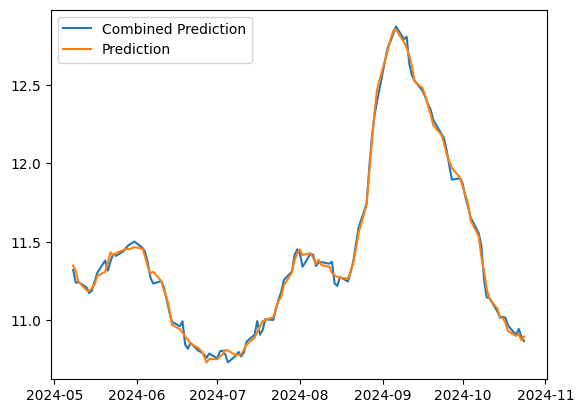

In [531]:
y_pred_flat = np.ravel(y_pred)
season_flat = np.ravel(season_full[-(len(y_pred_flat) + days_to_predict): -days_to_predict])

# Somar as duas séries
y_combined = np.add(y_pred_flat, season_flat)

# Ajustar o índice de y_combined
index_combined = index_test[-len(y_combined):]

# Plotar o resultado com o índice correto
plt.plot(index_combined, y_combined, label="Combined Prediction")
plt.plot(index_combined, y_pred_flat, label="Prediction")
# plt.plot(index_combined, season_flat, label="Seasonal Component")
plt.legend()
plt.show()

In [532]:
dados_forward = dados.copy()
last_pred = y_pred[-1]
feed_preds = []

for d in range(days_to_predict):
    dados_forward = increment_data_df(dados_forward, last_pred, d)
    X_fwd, y_fwd, X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = split_X_y(dados_forward)
    last_pred = modelo_lstm.predict(X_fwd[-n_past:-1])[-1]

    dados_forward.loc[dados_forward.index[-1], 'tomorrow'] = last_pred
    feed_preds.append(last_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

In [533]:
fig = go.Figure()

# Linha do dataset original 'dados'
fig.add_trace(go.Scatter(x=dados.index[-(days_to_predict*5):], 
                         y=dados[target][-(days_to_predict*5):], 
                         mode='lines', 
                         name='Dados Anteriores'))

# Linha dos dados previstos 'dados_forward'
fig.add_trace(go.Scatter(x=dados_forward.index[-(days_to_predict+1):], 
                         y=dados_forward[target][-(days_to_predict+1):], 
                         mode='lines', 
                         name='Previsões'))

# Ajuste dos rótulos do eixo x e rotação
fig.update_layout(
    xaxis=dict(tickangle=-90),  # Rotação vertical dos rótulos
    title="Previsão de Fechamento",
    xaxis_title="Data",
    yaxis_title="Valor Fechamento",
    legend_title="Legenda",
    height=600,
    width=900
)

# Exibindo o gráfico
fig.show()